# **CNN Melanoma Detection Assingnment**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
  

### Importing all the important libraries

In [115]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [116]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [117]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN/Test')

In [118]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [119]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [120]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [121]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [122]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

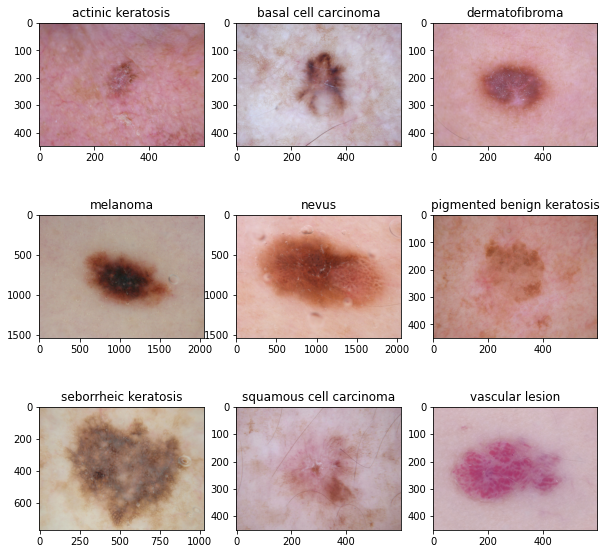

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [124]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [125]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [126]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
# View the summary of all layers
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

### Train the model

In [128]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 181s 688ms/step - loss: 2.0868 - accuracy: 0.1767 - val_loss: 2.0500 - val_accuracy: 0.1492
Epoch 2/20
57/57 [==============================] - 4s 70ms/step - loss: 2.0027 - accuracy: 0.2344 - val_loss: 2.0567 - val_accuracy: 0.1960
Epoch 3/20
57/57 [==============================] - 4s 70ms/step - loss: 2.0276 - accuracy: 0.2117 - val_loss: 2.0228 - val_accuracy: 0.2272
Epoch 4/20
57/57 [==============================] - 4s 70ms/step - loss: 1.9853 - accuracy: 0.2433 - val_loss: 1.9856 - val_accuracy: 0.1782
Epoch 5/20
57/57 [==============================] - 4s 70ms/step - loss: 1.9714 - accuracy: 0.2272 - val_loss: 1.9795 - val_accuracy: 0.2272
Epoch 6/20
57/57 [==============================] - 4s 70ms/step - loss: 1.9514 - accuracy: 0.2494 - val_loss: 1.9404 - val_accuracy: 0.2561
Epoch 7/20
57/57 [==============================] - 4s 70ms/step - loss: 1.9532 - accuracy: 0.2506 - val_loss: 1.9822 - val_accuracy: 0.2138
Epoch 8/20
57/57 [===

### Visualizing training results

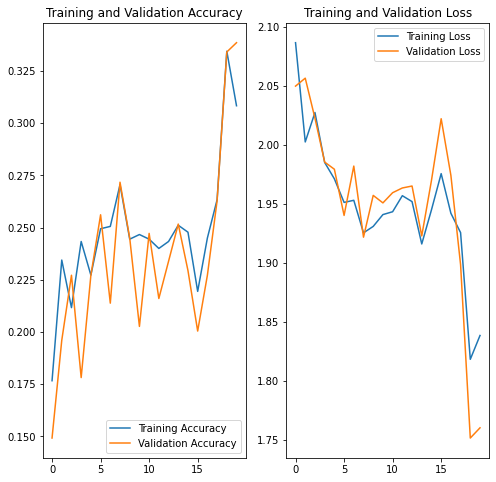

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Initial findings 

The model is overfitting because overfitting is calculated w.
r.t loss, and we can also see difference in loss functions in training & test around the 19-20th epoch

The accuracy is just around 50-60% because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs)




### Write your findings here

In [130]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

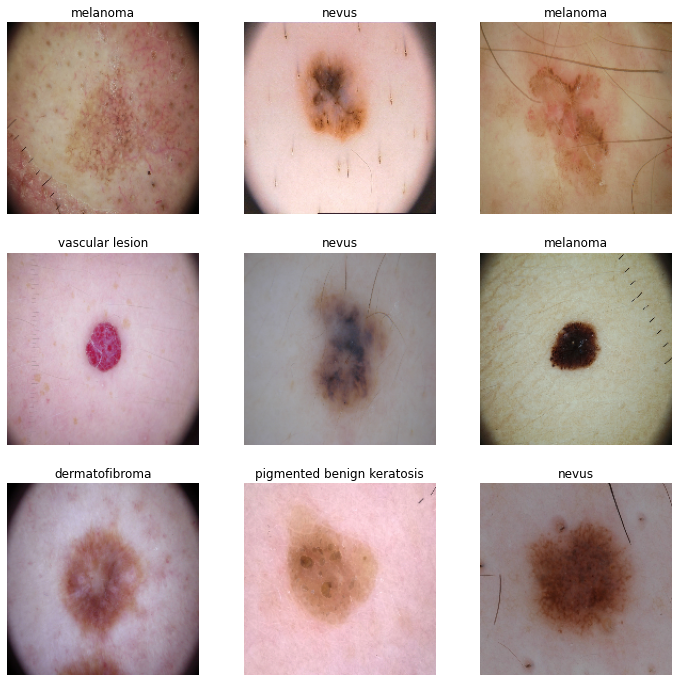

In [131]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model


In [132]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [133]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [134]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 5s 76ms/step - loss: 2.0671 - accuracy: 0.1917 - val_loss: 2.0351 - val_accuracy: 0.1915
Epoch 2/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0777 - accuracy: 0.2278 - val_loss: 2.0389 - val_accuracy: 0.1960
Epoch 3/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0391 - accuracy: 0.2044 - val_loss: 2.0299 - val_accuracy: 0.1960
Epoch 4/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0684 - accuracy: 0.1922 - val_loss: 2.0225 - val_accuracy: 0.1960
Epoch 5/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0231 - accuracy: 0.2039 - val_loss: 2.0363 - val_accuracy: 0.1960
Epoch 6/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0230 - accuracy: 0.2100 - val_loss: 2.0221 - val_accuracy: 0.1915
Epoch 7/20
57/57 [==============================] - 4s 73ms/step - loss: 2.0186 - accuracy: 0.2078 - val_loss: 2.0205 - val_accuracy: 0.1915
Epoch 8/20
57/57 [======

### Visualizing the results

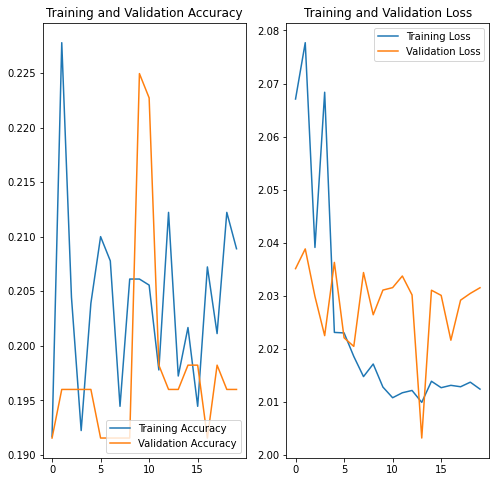

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Findings

We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation

####  Find the distribution of classes in the training dataset.


In [136]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
1,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
2,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
3,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
4,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2245,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2246,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2247,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion


In [137]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
1,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
2,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
3,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
4,/content/gdrive/MyDrive/CNN/Train/actinic kera...,actinic keratosis
...,...,...
2244,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2245,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2246,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion
2247,/content/gdrive/MyDrive/CNN/Train/vascular les...,vascular lesion


<BarContainer object of 9 artists>

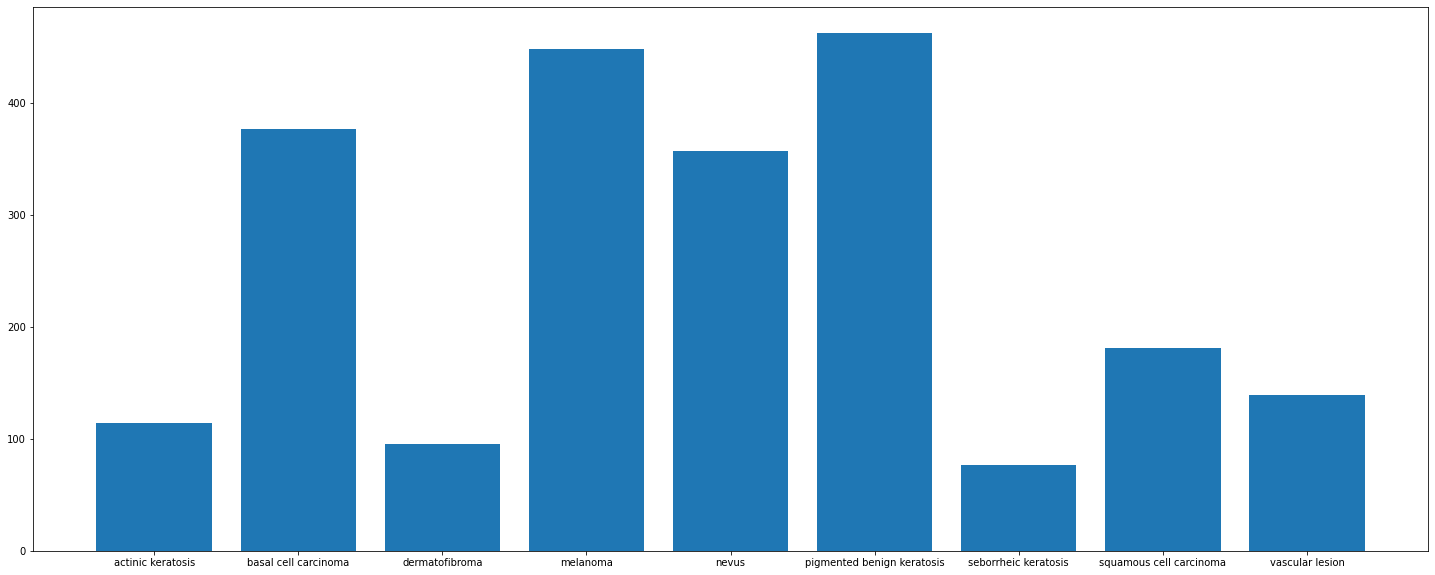

In [138]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Findings

- Seborrheic keratosis is having the lowest distribution
- Pigmented Benign keratosis is having the highest distribution of data

#### Rectify the class imbalance

In [139]:
!pip install Augmentor

In [140]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F561316B610>: 100%|██████████| 500/500 [00:09<00:00, 55.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56103E6390>: 100%|██████████| 500/500 [00:09<00:00, 51.93 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F562A308A50>: 100%|██████████| 500/500 [00:10<00:00, 49.44 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F561028D5D0>: 100%|██████████| 500/500 [00:48<00:00, 10.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5610198350>: 100%|██████████| 500/500 [00:40<00:00, 12.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F56132B0810>: 100%|██████████| 500/500 [00:08<00:00, 55.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5612F2AB50>: 100%|██████████| 500/500 [00:20<00:00, 24.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F56102D2090>: 100%|██████████| 500/500 [00:08<00:00, 57.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5613045CD0>: 100%|██████████| 500/500 [00:09<00:00, 54.46 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [141]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [142]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0024475.jpg_6830fce4-05f0-4dad-b028-ef2840726e95.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_56691842-3862-46c3-a2d7-138233019b95.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0027210.jpg_ceb3e4c2-d754-4e17-9b56-94d81ea82def.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0031950.jpg_d7657820-00a0-4016-9baf-856d5122413a.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_df5d513a-a66c-417f-937c-4b38e6096448.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0033749.jpg_511d771c-e9b6-4db2-87f5-49aa25dbe0bc.jpg',
 '/content/gdrive/MyDrive/CNN/Train/vascular lesion/output/vascular lesion_original_ISIC_0030104.jpg_4e438853-b61b-4124-99f0-6a7adff7c81

In [143]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [144]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [145]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [146]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      948
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [147]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [148]:
data_dir_train="/content/gdrive/MyDrive/CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [149]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Create your model (make sure to include normalization)

In [150]:
## your code goes here
input_shape = (180,180,3)
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 90, 90, 64)      

#### Compile your model (Choose optimizer and loss function appropriately)

In [151]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### Train your model

In [152]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 28s 153ms/step - loss: 0.0000e+00 - accuracy: 0.1335 - val_loss: 0.0000e+00 - val_accuracy: 0.1149 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 21s 118ms/step - loss: 0.0000e+00 - accuracy: 0.1335 - val_loss: 0.0000e+00 - val_accuracy: 0.1149 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 21s 122ms/step - loss: 0.0000e+00 - accuracy: 0.1335 - val_loss: 0.0000e+00 - val_accuracy: 0.1149 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1335
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 21s 117ms/step - loss: 0.0000e+00 - accuracy: 0.1335 - val_loss: 0.0000e+00 - val_accuracy: 0.1149 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 21s 118ms/step - loss: 0.0000e+00 - accuracy: 0.1335 - val_loss: 0.0000e+00 - val_accuracy: 0.1149 - lr: 5.0000e-04
E

#### Visualize the model results

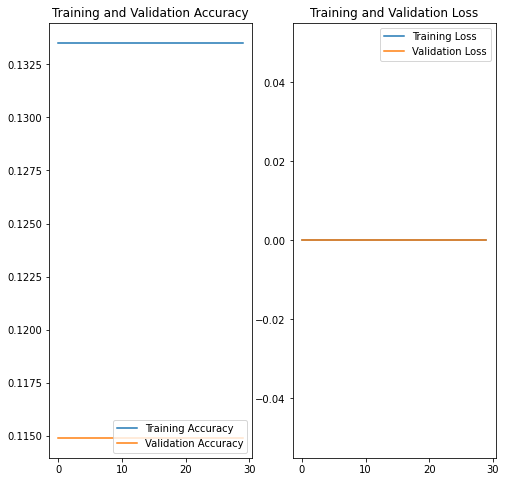

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Did you get rid of underfitting/overfitting? Did class rebalance help?

The class rebalance helped in reducing overfititng of the data and thus the loss is beng reduced at the cost of accuracy.
